In [13]:
%pip install pykalman


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.model_selection import train_test_split
import pykalman


In [15]:
start_date = datetime.datetime(2013, 1, 1)
end_date = datetime.datetime(2019, 1, 1)

stock_symbols = ['ADBE', 'MSFT']

stock_prices = yf.download(stock_symbols, start_date, end_date)['Close']
stock_prices.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2018-12-24,205.160004,88.722115
2018-12-26,222.949997,94.782722
2018-12-27,225.139999,95.367088
2018-12-28,223.130005,94.622505
2018-12-31,226.240005,95.734695


In [16]:
def kalman_filter_regression(stock_x, stock_y):
    from pykalman import KalmanFilter

    delta = 1e-3
    transition_covariance = delta / (1 - delta) * np.eye(2)
    observation_matrix = np.expand_dims(np.vstack([[stock_x], [np.ones(len(stock_x))]]).T, axis=1)

    kalman_filter = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=observation_matrix,
                      observation_covariance=2,
                      transition_covariance=transition_covariance)

    state_means, state_covariances = kalman_filter.filter(stock_y.values)
    return state_means

In [17]:
def calculate_trading_pnl(stock_data, kalman_states, price_spread, trans_cost=0.0005):
    rolling_mean = price_spread.rolling(window=30).mean()
    rolling_std = price_spread.rolling(window=30).std()
    normalized_spread = (price_spread - rolling_mean) / rolling_std

    trading_signals = pd.Series(0, index=stock_data.index)
    trading_signals[normalized_spread < -2] = 1  
    trading_signals[normalized_spread > 2] = -1  
    trading_signals[(normalized_spread > -0) & (trading_signals == 1)] = 0  
    trading_signals[(normalized_spread < 0) & (trading_signals == -1)] = 0  
    trading_signals = trading_signals.ffill().fillna(0)

    hedge_ratio = kalman_states[:, 1]
    spread_returns = price_spread.diff() / (stock_data['ADBE'] * abs(hedge_ratio) + stock_data['MSFT'])
    portfolio_returns = spread_returns * trading_signals.shift(1)

    signal_changes = trading_signals.diff().fillna(0)
    portfolio_returns -= abs(signal_changes) * trans_cost

    cumulative_returns = (1 + portfolio_returns).cumprod()

    return cumulative_returns

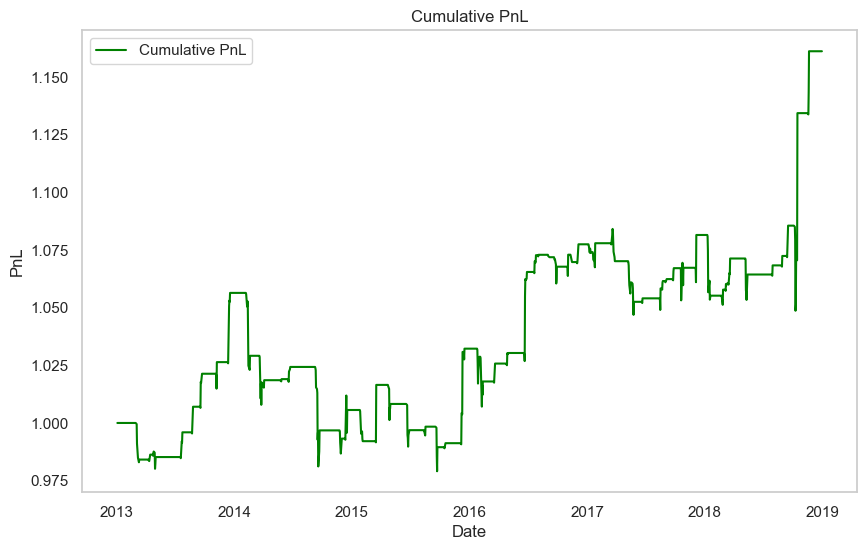

In [20]:
state_means = kalman_filter_regression(stock_prices['ADBE'], stock_prices['MSFT'])
price_spread = stock_prices['MSFT'] - (state_means[:, 0] + state_means[:, 1] * stock_prices['ADBE'])

cumulative_returns = calculate_trading_pnl(stock_prices, state_means, price_spread)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Cumulative PnL', color='green')
plt.title('Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()